<a href="https://colab.research.google.com/github/awenroberts/QM2-Project/blob/main/protests_visualisation_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Spatial graph and data analisis

In [129]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pylab
from datetime import datetime

%matplotlib inline
pylab.rcParams['figure.figsize'] = (10, 8)

In [130]:
#from google.colab import files
#uploaded = files.upload()

In [131]:
df = pd.read_excel("/content/QM2 Project protests data (1).xlsx",
                   sheet_name="2025",
                   engine='openpyxl')
df.head()

,event_id,date,location_name,town_city,postcode,description,v,wiki ref,source,source_url
0,E0001,2025-04-13,Hotel used to house asylum seekers,Paisley,PA1 1DD,Protest by 'Fighting Justice Against Predators...,NaN,44,Morning Star,https://morningstaronline.co.uk/article/far-ri...
1,E0002,2025-04-15,Rally (mass-deportations),Portsmouth,PO1 2AB,UKIP rally; Nick Tenconi attended; counter-pro...,NaN,46,The News,https://www.portsmouth.co.uk/news/people/ports...
2,E0003,2025-04-27,Town centre → Market Square march,Dover,CT16 1NU,'Kent Motor Heads' anti-illegal-immigration pr...,NaN,47,BBC News,https://www.bbc.com/news/articles/cy4j4pdrj3eo
3,E0004,2025-05-17,City centre march → Victoria Square,Birmingham,B11BD,Britain First supporters marched; council said...,NaN,49,Birmingham Mail,https://www.birminghammail.co.uk/news/midlands...
4,E0005,2025-05-17,City centre rally (mass-deportations),Bristol,BS1 4SB,UKIP rally (~100) opposed by larger counter-pr...,NaN,51,Bristol Live,https://www.bristolpost.co.uk/news/bristol-new...


In [132]:
import pandas as pd

xls = pd.ExcelFile("/content/QM2 Project protests data (1).xlsx")
print("Available Excel sheets:", xls.sheet_names)

Available Excel sheets: ['isla manual', 'Sheet1', '2024', '2025']


In [133]:
!pip install pgeocode

import pgeocode
geo = pgeocode.Nominatim("gb")

In [134]:
df["postcode"] = (
    df["postcode"]
    .astype(str)
    .str.upper()
    .str.strip()
)

In [135]:
df.loc[df["postcode"] == "B11BD", "postcode"] = "B1 1BD"

In [136]:
df.loc[df["postcode"] == "1 1JW", "postcode"] = "L1 1JW"

In [137]:
coords = df["postcode"].apply(geo.query_postal_code)

df["latitude"] = coords["latitude"]
df["longitude"] = coords["longitude"]

df.head()

,event_id,date,location_name,town_city,postcode,description,v,wiki ref,source,source_url,latitude,longitude
0,E0001,2025-04-13,Hotel used to house asylum seekers,Paisley,PA1 1DD,Protest by 'Fighting Justice Against Predators...,NaN,44,Morning Star,https://morningstaronline.co.uk/article/far-ri...,55.831700,-4.432500
1,E0002,2025-04-15,Rally (mass-deportations),Portsmouth,PO1 2AB,UKIP rally; Nick Tenconi attended; counter-pro...,NaN,46,The News,https://www.portsmouth.co.uk/news/people/ports...,50.799900,-1.089850
2,E0003,2025-04-27,Town centre → Market Square march,Dover,CT16 1NU,'Kent Motor Heads' anti-illegal-immigration pr...,NaN,47,BBC News,https://www.bbc.com/news/articles/cy4j4pdrj3eo,51.147075,1.289725
3,E0004,2025-05-17,City centre march → Victoria Square,Birmingham,B1 1BD,Britain First supporters marched; council said...,NaN,49,Birmingham Mail,https://www.birminghammail.co.uk/news/midlands...,52.481400,-1.899800
4,E0005,2025-05-17,City centre rally (mass-deportations),Bristol,BS1 4SB,UKIP rally (~100) opposed by larger counter-pr...,NaN,51,Bristol Live,https://www.bristolpost.co.uk/news/bristol-new...,51.455200,-2.596600


In [138]:
df = df.dropna(subset=["latitude", "longitude"])
print("Remaining events:", len(df))


Remaining events: 118


In [139]:
city_coords = (
    df.groupby("town_city")[["latitude", "longitude"]]
      .mean()
      .reset_index()
)

city_coords.head()

,town_city,latitude,longitude
0,Aberdeen,57.14370,-2.098100
1,Altrincham,53.38524,-2.365540
2,Ashford,51.15110,0.890813
3,Barnwood (Gloucester),51.82706,-2.187810
4,Basingstoke,51.26250,-1.087100


In [140]:
def haversine(lat1, lon1, lat2, lon2):
    R = 6371
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat/2)**2 + np.cos(lat1)*np.cos(lat2)*np.sin(dlon/2)**2
    return 2 * R * np.arcsin(np.sqrt(a))

In [141]:
import networkx as nx

G = nx.Graph()

# Add nodes with coordinates
for _, row in city_coords.iterrows():
    G.add_node(
        row["town_city"],
        lat=row["latitude"],
        lon=row["longitude"]
    )

In [142]:
threshold_km = 100

for i, r1 in city_coords.iterrows():
    for j, r2 in city_coords.iterrows():
        if i < j:
            d = haversine(
                r1.latitude, r1.longitude,
                r2.latitude, r2.longitude
            )
            if d <= threshold_km:
                G.add_edge(r1.town_city, r2.town_city, distance=d)

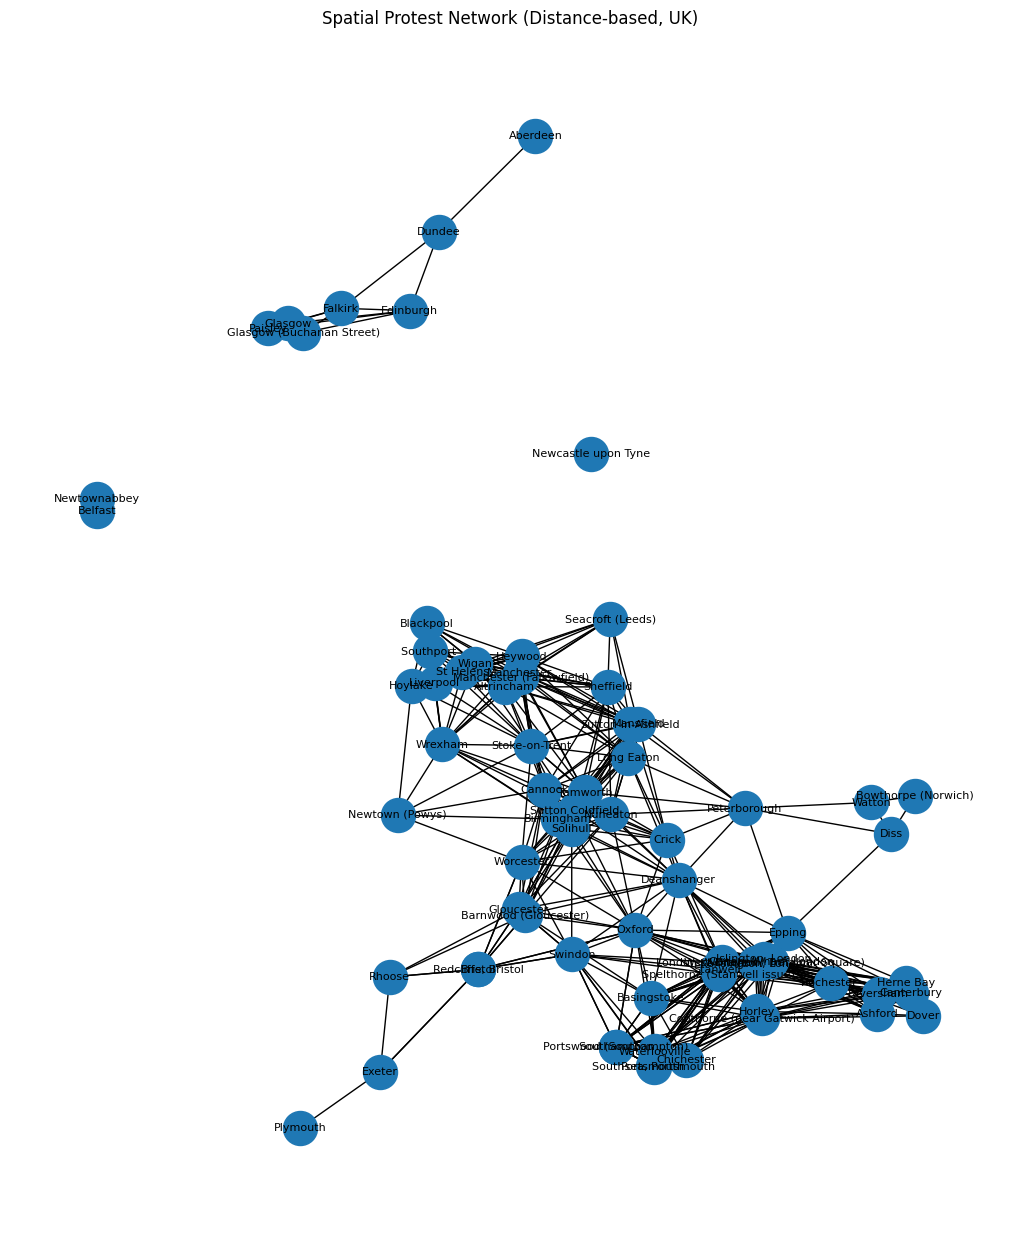

In [143]:
plt.figure(figsize=(10, 12))

pos = {
    n: (G.nodes[n]["lon"], G.nodes[n]["lat"])
    for n in G.nodes()
}

nx.draw(
    G,
    pos,
    with_labels=True,
    node_size=600,
    font_size=8
)

plt.title("Spatial Protest Network (Distance-based, UK)")
plt.show()

In [144]:
!rm /content/LAD_MAY_2025_UK_BFC_V2_481919774574330966 (1).geojson

/bin/bash: -c: line 1: syntax error near unexpected token `('
/bin/bash: -c: line 1: `rm /content/LAD_MAY_2025_UK_BFC_V2_481919774574330966 (1).geojson'


In [145]:
import geopandas as gpd

uk_map = gpd.read_file("/content/LAD_MAY_2025_UK_BFC_V2_481919774574330966 (1).geojson")
uk_map.head()

,FID,LAD25CD,LAD25NM,LAD25NMW,BNG_E,BNG_N,LONG,LAT,GlobalID,geometry
0,1,E06000001,Hartlepool,,447161,531473,-1.270174,54.676132,847f2c4b-a7cf-4c71-840c-0864853246d5,"MULTIPOLYGON (((-1.2247 54.62611, -1.22493 54...."
1,2,E06000002,Middlesbrough,,451141,516887,-1.210998,54.544679,f1925b75-6267-417d-a77a-05cdc4c6b1b3,"MULTIPOLYGON (((-1.2772 54.54784, -1.27721 54...."
2,3,E06000003,Redcar and Cleveland,,464330,519596,-1.006565,54.567520,36b1db27-3dfa-4ed6-8e81-36bf3abeeacc,"MULTIPOLYGON (((-1.20098 54.57763, -1.2003 54...."
3,4,E06000004,Stockton-on-Tees,,444940,518179,-1.306646,54.556876,22a6adf7-e812-4c09-89b1-6753ec35de93,"MULTIPOLYGON (((-1.27211 54.55337, -1.27213 54..."
4,5,E06000005,Darlington,,428029,515648,-1.568356,54.535345,309364b5-9b5c-4f9c-81f5-8a3a79699fd1,"POLYGON ((-1.63768 54.61714, -1.63767 54.6167,..."


In [146]:
!ls /content

'Copy support-local-authority-datasets-sep-2025 (4).xlsx'
'LAD_MAY_2025_UK_BFC_V2_481919774574330966 (1).geojson'
 la_exposure_exceldf.xlsx
'QM2 Project protests data (1).xlsx'
 sample_data


In [147]:
uk_map = uk_map.to_crs("EPSG:4326")

In [148]:
from shapely.geometry import Point
import pandas as pd

city_df = pd.DataFrame({
    "city": list(G.nodes()),
    "latitude": [G.nodes[n]["lat"] for n in G.nodes()],
    "longitude": [G.nodes[n]["lon"] for n in G.nodes()]
})

geometry = [Point(xy) for xy in zip(city_df["longitude"], city_df["latitude"])]
city_gdf = gpd.GeoDataFrame(city_df, geometry=geometry, crs="EPSG:4326")

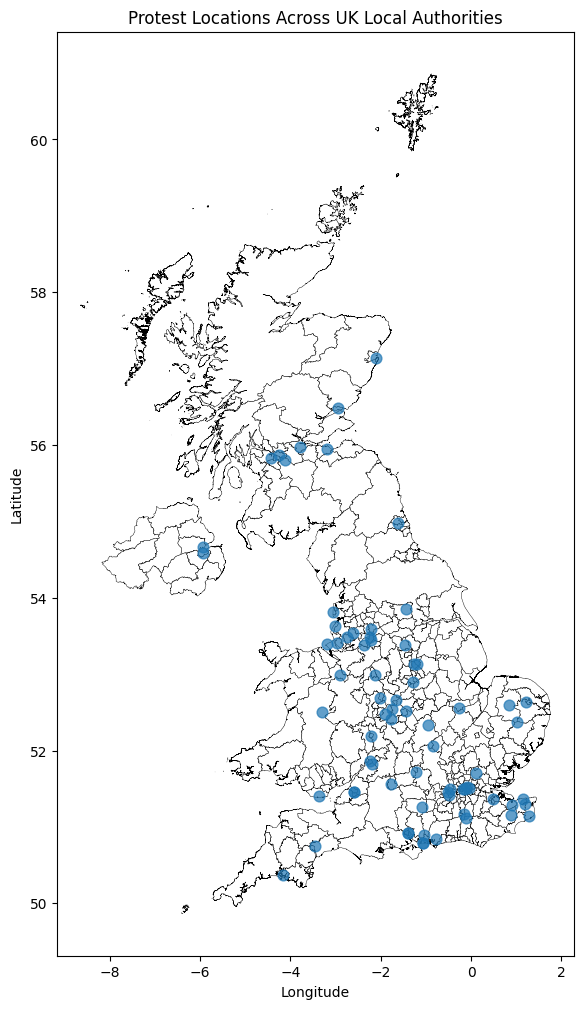

In [149]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 12))

# Plot local authority boundaries
uk_map.plot(
    ax=ax,
    color="white",
    edgecolor="black",
    linewidth=0.3
)

# Plot protest city points
city_gdf.plot(
    ax=ax,
    markersize=60,
    alpha=0.7
)

ax.set_title("Protest Locations Across UK Local Authorities")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")

plt.show()

In [150]:
import geopandas as gpd
from shapely.geometry import Point

# Create geometry column from lat/lon
geometry = [Point(xy) for xy in zip(df["longitude"], df["latitude"])]

gdf = gpd.GeoDataFrame(df, geometry=geometry, crs="EPSG:4326")


In [151]:
uk_map = uk_map.to_crs(epsg=4326)

In [152]:
gdf_with_la = gpd.sjoin(
    gdf,
    uk_map,
    how="left",
    predicate="within"
)

uk_map.columns

Index(['FID', 'LAD25CD', 'LAD25NM', 'LAD25NMW', 'BNG_E', 'BNG_N', 'LONG',
       'LAT', 'GlobalID', 'geometry'],
      dtype='object')

In [153]:
gdf_with_la["local_authority"] = gdf_with_la["LAD25NM"]

In [154]:
#gdf_with_la[["event_id", "town_city", "postcode", "local_authority", "LAD25CD"]].head()
protests_df = gdf_with_la[["event_id", "town_city", "postcode", "local_authority", "LAD25CD"]]

#rename the columns to make things easier later
protests_df = protests_df.rename(columns={
    "LAD25CD": "lad_code",
})

protests_df

,event_id,town_city,postcode,local_authority,lad_code
0,E0001,Paisley,PA1 1DD,Renfrewshire,S12000038
1,E0002,Portsmouth,PO1 2AB,Portsmouth,E06000044
2,E0003,Dover,CT16 1NU,Dover,E07000108
3,E0004,Birmingham,B1 1BD,Birmingham,E08000025
4,E0005,Bristol,BS1 4SB,"Bristol, City of",E06000023
...,...,...,...,...,...
121,E0084,Dundee,DD4 8UA,Dundee City,S12000042
122,E0085,Southport,PR8 1SB,Sefton,E08000014
123,E0086,Herne Bay,CT6 5JQ,Canterbury,E07000106
124,E0077,Sheffield,S1 2LA,Sheffield,E08000039


In [155]:
protests_df.dtypes

,0
event_id,object
town_city,object
postcode,object
local_authority,object
lad_code,object


In [156]:

#change the data types accordingly so we can work with the data usign pandas
protests_df['event_id']=protests_df['event_id'].astype('string')
protests_df['town_city']=protests_df['town_city'].astype('category')
protests_df['postcode']=protests_df['postcode'].astype('category')
protests_df['local_authority']=protests_df['local_authority'].astype('category')

In [157]:
import pandas as pd

xls = pd.ExcelFile("/content/Copy support-local-authority-datasets-sep-2025 (4).xlsx")
print("Available Excel sheets:", xls.sheet_names)


pop_df = pd.read_excel(
    "/content/Copy support-local-authority-datasets-sep-2025 (4).xlsx",
    sheet_name="population_per_LA", # Changed to include the trailing space
    header=0,
    engine="openpyxl"
)
pop_df.head()

Available Excel sheets: ['Cover_sheet', 'Contents', 'Notes', 'List_of_Fields', 'Asy_D11', 'Data_Asy_D11', 'Data_Asy_D11_2020_2025', 'population_per_LA', 'population for local authoritie', 'la_exposure_table', 'protest_data', '2025', 'Sheet1']


,lad_code,name,geography,population,Isy
0,E07000223,Adur,Non-metropolitan District,64889,True
1,E07000032,Amber Valley,Non-metropolitan District,130451,True
2,E07000224,Arun,Non-metropolitan District,170064,True
3,E07000170,Ashfield,Non-metropolitan District,129572,True
4,E07000105,Ashford,Non-metropolitan District,140936,True


In [158]:
pop_df.columns
pop_df["lad_code"].nunique()


314

In [159]:
df_contingency = pd.read_excel(
    "/content/la_exposure_exceldf.xlsx",
    engine="openpyxl"
)
df_contingency.head()

,index,lad_code,local_authority,population,total_asylum,contingency_per_1000,contingency_share,delta_contingency_Q1_Q3
0,0,E09000008,Croydon,409342.0,1270,0.024429,0.007874,83.0
1,1,E09000007,Camden,216943.0,250,0.009219,0.008000,43.0
2,2,E09000005,Brent,352976.0,1076,0.121821,0.039963,-49.0
3,3,E09000003,Barnet,405050.0,1588,0.004938,0.001259,-59.0
4,4,E09000003,Barnet,405050.0,1588,0.069127,0.017632,-59.0


In [163]:
df_contingency = pd.read_excel(
    "/content/Copy support-local-authority-datasets-sep-2025 (4).xlsx",
    sheet_name="la_exposure_table",
    engine="openpyxl"
)
df_contingency.head()

,lad_code,local_authority,population,total_asylum,contingency_per_1000,contingency_share,delta_contingency_Q1_Q3
0,S12000033,Aberdeen City,NaN,624,NaN,0.083333,85.0
1,S12000033,Aberdeen City,NaN,624,NaN,0.533654,85.0
2,S12000034,Aberdeenshire,NaN,358,NaN,0.131285,82.0
3,S12000034,Aberdeenshire,NaN,358,NaN,0.796089,82.0
4,N09000001,Antrim and Newtownabbey,NaN,165,NaN,0.121212,-8.0


In [164]:
print("local_authorities:", len(df_contingency))

local_authorities: 348


In [171]:
uk_map = uk_map.merge(
    df_contingency,
    left_on="LAD25NM", # Corrected from "local_authority"
    right_on="local_authority",
    how="left"
)

uk_map[["local_authority", "contingency_per_1000", "contingency_share", "delta_contingency_Q1_Q3"]].head()

,local_authority,contingency_per_1000,contingency_share,delta_contingency_Q1_Q3
0,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN
3,Stockton-on-Tees,0.062863,0.016149,12.0
4,NaN,NaN,NaN,NaN


In [172]:
map_codes = set(uk_map["LAD25CD"])
data_codes = set(df_contingency["lad_code"])

print("Map authorities:", len(map_codes))
print("Data authorities:", len(data_codes))
print("Matching authorities:", len(map_codes & data_codes))

Map authorities: 361
Data authorities: 129
Matching authorities: 128


In [173]:
df_contingency["lad_code"].str[0].value_counts()

,count
lad_code,
E,114
S,11
N,3
W,1


In [174]:
map_with_data = uk_map[uk_map["contingency_per_1000"].notna()]

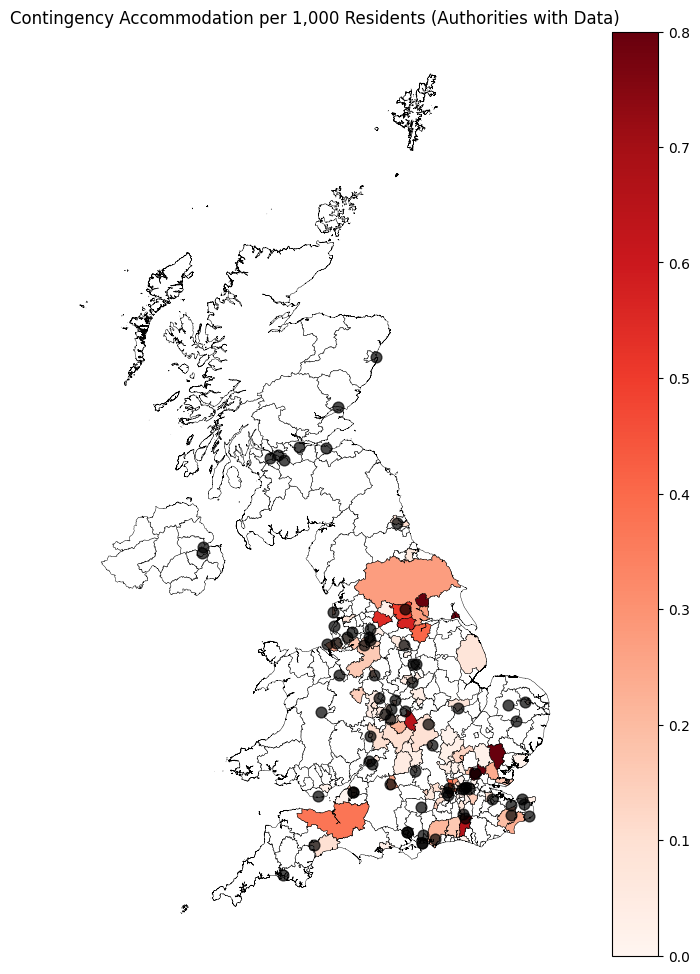

In [195]:
fig, ax = plt.subplots(figsize=(10, 12))

uk_map.plot(
    ax=ax,
    color="white",
    edgecolor="black",
    linewidth=0.3
)


map_with_data.plot(
    column="contingency_per_1000",
    cmap="Reds",
    legend=True,
    linewidth=0.3,
    edgecolor="black",
     vmin=0,
    vmax=0.8,
    ax=ax
)

city_gdf.plot(
    ax=ax,
    markersize=60,
    color="black",
    alpha=0.7
)

ax.set_title("Contingency Accommodation per 1,000 Residents (Authorities with Data)")
ax.axis("off")

plt.show()

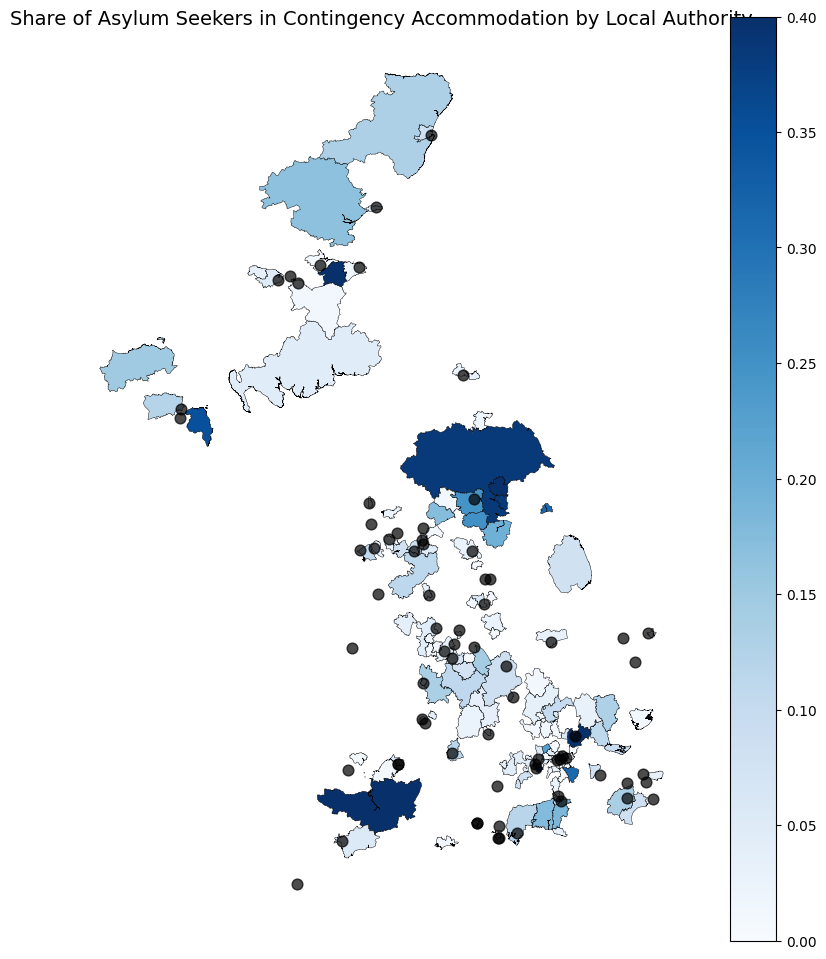

In [189]:
fig, ax = plt.subplots(1, 1, figsize=(10, 12))

uk_map.plot(
    column="contingency_share",
    cmap="Blues",
    linewidth=0.3,
    edgecolor="black",
    legend=True,
     vmin=0,
    vmax=0.4,
    ax=ax
)

city_gdf.plot(
    ax=ax,
    markersize=60,
    color="black",
    alpha=0.7
)

ax.set_title("Share of Asylum Seekers in Contingency Accommodation by Local Authority", fontsize=14)
ax.axis("off")

plt.show()

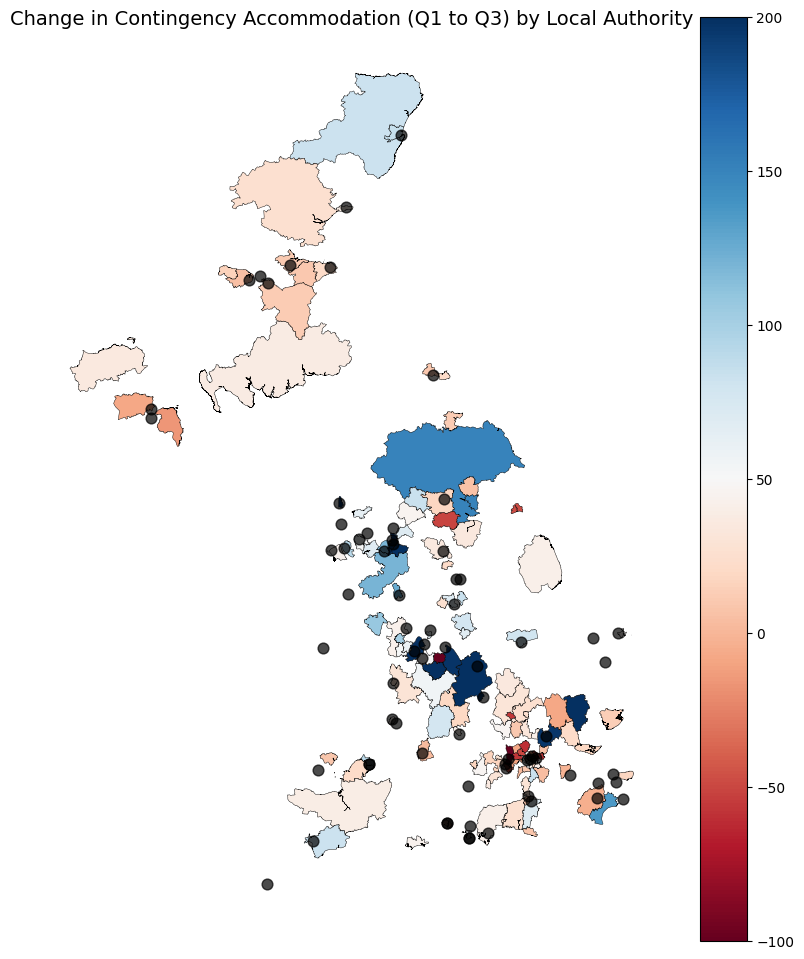

In [193]:
fig, ax = plt.subplots(1, 1, figsize=(10, 12))

uk_map.plot(
    column="delta_contingency_Q1_Q3",
    cmap="RdBu",
    linewidth=0.3,
    edgecolor="black",
    legend=True,
     vmin=-100,
    vmax=200,
    ax=ax
)

city_gdf.plot(
    ax=ax,
    markersize=60,
    color="black",
    alpha=0.7
)

ax.set_title("Change in Contingency Accommodation (Q1 to Q3) by Local Authority", fontsize=14)
ax.axis("off")

plt.show()